# Aerial Project

<img src="img/logo.jpg" width=150 ALIGN="left" border="20">

## Starting Kit for raw data (images)

Created by Aerial Team

ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The CDS, CHALEARN, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL, INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE.

## Introduction

Aerial imagery has been a primary source of geographic data for quite a long time. With technology progress, aerial imagery became really practical for remote sensing : the science of obtaining information about an object, area or phenomenon.
Nowadays, there are many uses of image recognition spanning from robotics/drone vision to autonomous driving vehicules or face detection.

In this challenge, we will use pre-processed data, coming from landscape images. The goal is to learn to differentiate common and uncommon landscapes such as a beach, a lake or a meadow.
Data comes from part of the data set (NWPU-RESISC45) originally used in the paper [*Remote Sensing Image Scene Classification*](https://arxiv.org/pdf/1703.00121.pdf). This data set contains 45 categories while we only kept 13 out of them.

**Challenge website:** https://codalab.lisn.upsaclay.fr/competitions/573#participate-submit_results

References and credits:

Yuliya Tarabalka, Guillaume Charpiat, Nicolas Girard for the data sets presentation.<br>
Gong Cheng, Junwei Han, and Xiaoqiang Lu, for the original article on the chosen data set.
</div>

### Requirements / Installation

```bash
conda create -n torch python=3
conda activate torch
conda install pytorch torchvision torchaudio -c pytorch
conda install ipykernel pyyaml pandas matplotlib scipy scikit-learn
```

Code tested with:

```
python=3.9.7
pytorch=1.10.0
pyyaml=6.0
pandas=1.3.4
matplotlib=3.5.0
scipy=1.7.1
scikit-learn=1.0.1
```

In [1]:
import os
import csv
import platform
import shutil
from collections import namedtuple
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import decomposition, metrics, model_selection, naive_bayes, pipeline
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from time import time
from tensorflow.keras.applications.resnet50 import ResNet50
from keras import backend as K

In [2]:
if platform.system() == "Darwin":
    %config InlineBackend.figure_format="retina"  # For high DPI display

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.0.1

1.0.2


In [3]:
DATA_PATH = Path("public_data")      # Uncomment to use FULL DATASET
# DATA_PATH = Path("sample_data")         # Sample dataset

SUBM_PATH = Path("submissions")
MODEL_PATH = Path("submission_code")
SCORE_PATH = Path("scoring_output")

RESULTS_PATH = SUBM_PATH / "submission_results"

DATA_NAME = "Areal"

DATA_SETS = ["train", "valid", "test"]
ALL_SETS = ["train", "valid-lab", "valid", "test"]

## Step 1: Exploratory data analysis

We provide sample_data with the starting kit, but to prepare your submission, you must fetch the public_data from the challenge website and point to it.

**<span style="color:red">Warning</span>**

*In case you want to load the full data*

Files being big, your computer needs to have enough space available in your RAM. It should take about 3-4GB while loading and 1.5GB in the end.

### Load data

In [4]:
def number_lines(fname):
    with open(fname) as f:
        return sum(1 for l in f)

In [5]:
def fast_import(arr, fpath):
    with open(fpath) as f:
        for i, row in enumerate(csv.reader(f, delimiter=" ")):
            arr[i] = row

In [6]:
num_fts = number_lines(DATA_PATH / f"{DATA_NAME}_feat.name")

num = {
    data_set: number_lines(DATA_PATH / f"{DATA_NAME}_{data_set}.data")
    for data_set in DATA_SETS
}

xs_raw = {
    data_set: np.empty((num[data_set], num_fts))
    for data_set in DATA_SETS
}

for data_set in DATA_SETS:
    fast_import(
        xs_raw[data_set], 
        fpath=DATA_PATH / f"{DATA_NAME}_{data_set}.data"
    )

In [7]:
labels_df = pd.read_csv(
    DATA_PATH / f"{DATA_NAME}_label.name", header=None, names=["name"]
)

labels = labels_df.name.to_list()

ys_df = pd.read_csv(
    DATA_PATH / f"{DATA_NAME}_train.solution", header=None, names=["value"]
)

ys_raw = ys_df.values

ys_df["label"] = ys_df.value.map(labels_df.name)

ys_df.head()

,value,label
0,5,island
1,0,beach
2,0,beach
3,1,chaparral
4,0,beach


### Visualize dataset sample

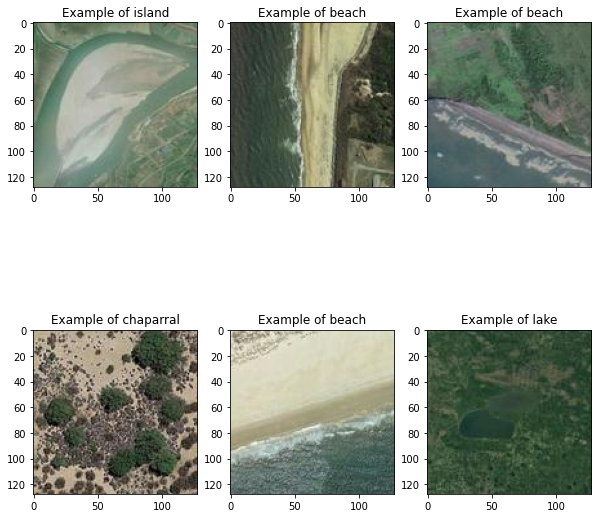

In [45]:
NUM_TO_SHOW = 6

fig, axs_ = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
fig.subplots_adjust(hspace=0.3)
axs = axs_.flatten()

for i in range(NUM_TO_SHOW):
    img = xs_raw["train"][i].reshape(128, 128, -1)
    label = ys_df.label[i]
    axs[i].set_title(f"Example of {label}")
    axs[i].imshow(img.astype(float) / 255)

plt.show()


## Step 2 : Building a predictive model

### Split and process the data

In [47]:
xs, ys = {}, {}
(
    xs["train"], 
    xs["valid-lab"], 
    ys["train"], 
    ys["valid-lab"]
) = model_selection.train_test_split(xs_raw["train"], ys_raw, random_state=123)

xs["test"], xs["valid"] = xs_raw["test"], xs_raw["valid"]


print(xs["train"].shape, ys["train"].shape)
print(xs["valid-lab"].shape, ys["valid-lab"].shape)
print(xs["valid"].shape)
print(xs["test"].shape)

(3900, 49152) (3900, 1)
(1300, 49152) (1300, 1)
(1950, 49152)
(1950, 49152)


In [48]:
SIZE = 128

x_processed = xs.copy()
x_processed = {
    data_set:  x_processed[data_set].reshape(-1,SIZE,SIZE,3)
    for data_set in ALL_SETS
}

y_processed = ys.copy()
y_processed = {
    data_set:  to_categorical(y_processed[data_set], num_classes=len(labels))
    for data_set in ["train", "valid-lab"]
}

### Build and train the model

In [128]:
BS = 32
n_epochs = 30

K.clear_session()

data_augmentation = Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)
])

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(SIZE,SIZE, 3), classes=len(labels))
base_model.trainable = False

model = Sequential([
    data_augmentation,
    base_model, 
    layers.Flatten(), 
    layers.Dense(2048, activation='relu'),
    layers.Dense(len(labels), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.000001), loss='categorical_crossentropy', metrics=['accuracy']) 

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

history = model.fit(x_processed['train'],y_processed['train'], validation_data=(x_processed['valid-lab'], y_processed['valid-lab']), 
  steps_per_epoch=len(x_processed['train']) // BS,
  epochs=n_epochs, verbose=0, callbacks=[tensorboard])

### Save the results

In [97]:
# save the model
model.save("model.h5")

# save the training history  
df_history = pd.DataFrame.from_dict(history.history)
df_history.to_csv("history.csv",index=None)

### Plot the results

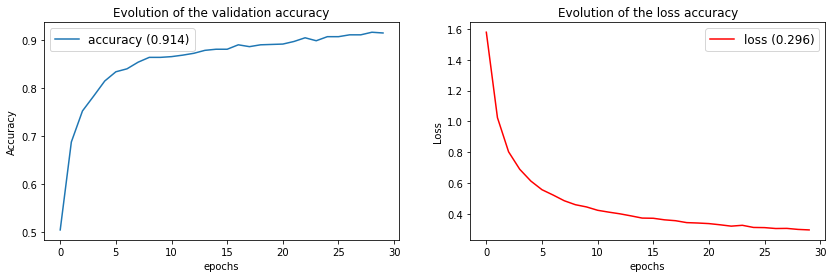

In [148]:
x_range = np.arange(0,n_epochs)
fig, axs = plt.subplots(1, 2,figsize=(14,4))

axs[0].plot(x_range, df_history['val_accuracy'],label="accuracy (0.914)")
axs[0].legend(loc="upper left",prop={'size': 12})
axs[0].set_title('Evolution of the validation accuracy')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('Accuracy')
axs[1].plot(x_range, df_history['val_loss'],color='red',label="loss (0.296)")
axs[1].legend(loc="upper right",prop={'size': 12})
axs[1].set_title('Evolution of the loss accuracy')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('Loss')
plt.show()

## Submission

### Prepare submission file

In [19]:
def make_submission(pred, delete_file = True):
        '''Create a submission zip
           pred should be an iterable collection of int
           make sure the prediction is in the right order'''
        output_filename = "Areal_valid"
        dir_name = "."
        if not os.path.exists(output_filename):
             os.makedirs(output_filename)
        file = open(output_filename +'/'+ output_filename + '.predict', "w")
        for i in pred:
            file.write(str(i) + '\n')
        file.close()
        shutil.make_archive(output_filename, 'zip', output_filename)
        if delete_file:
            shutil.rmtree(output_filename)
        print("Submission Ready") 

make_submission()

Submit one of these files:
{subm_code_name}
{subm_results_name}


---